In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [105]:
import argparse
args = argparse.Namespace(
    # Model setting
    float_type='bfloat16',
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-large",
    language_model_train=False,
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    loc_vocab_size=1600,
    additional_vocab_size=10000,
    vae_ckpt_path='',
    max_source_length=64,
    max_target_length=64,
    # Train setting
    stage="finetune", 
    loss='CrossEntropy',
    # Dir setting
    root_dir="/data01/",
    # result_dir="results/finetune/deepfashion2_det/id/pretrain/Linear30_1e-4",
    # result_dir='results/finetune/hico/id/pretrain/Linear50_1e-4/'
    result_dir='results/finetune/vcoco/id/pretrain/Linear50_1e-4/'
)

In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = MyModel(args).to(device)
model.load(result_name='best.pth')

cuda


In [107]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")

Total params: 699419764
Trainable params: 162985728


In [108]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_source_length)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(args.loc_vocab_size)] + [f"<add_{i}>" for i in range(args.additional_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [109]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [110]:
from PIL import ImageDraw
def show_result(dataset, idx=10, src_loc=True, is_mask=False, given_src_text=None):
    src_image, image_path, src_text, tgt_text = dataset[idx]
    if given_src_text:
        src_text = given_src_text
    print(image_path)
    scale = 256 / 40
    bias = scale // 2
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        if is_mask:
            src_image = torch.zeros_like(src_image).to(device)
        encoded_src_text = src_tokenizer.encode(src_text, return_tensors='pt').to(device)

        pil = custom_to_pil(src_image[0])
        display(pil)

        if '<loc_' in src_text and src_loc:
            draw = ImageDraw.Draw(pil)
            locs = src_text.split()
            i = 0
            for loc in locs:
                if '<loc_' in loc:
                    i += 1
                    label, l1, l2 = loc.split('<loc_')
                    l2 = l2.rstrip('?')
                    left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                    color = "blue" if i == 1 else "green"
                    draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline=color, width=3)
                    draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill=color)
            display(pil)
            
        outputs = model(src_image, encoded_src_text, None, return_loss=False, num_beams=4)
        outputs = outputs[:, 1:]
        # for tok, score in zip(outputs[0], score[0]):
        #     print(f"| {tok:5d} | {tgt_tokenizer.decode(tok):8s} | {score.cpu().numpy():.4f} | {np.exp(score.cpu().numpy()):.2%}")
        pred = tgt_tokenizer.decode(outputs[0][:-1])
        
        if '<loc_' in tgt_text:
            draw = ImageDraw.Draw(pil)
            locs = tgt_text.split('> ')
            for loc in locs:
                label, l1, l2 = loc.split('<loc_')
                left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='green', width=3)
                draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill='green')
            display(pil)
        if '<loc_' in pred:
            pil = custom_to_pil(src_image[0])
            draw = ImageDraw.Draw(pil)
            locs = pred.split('> ')
            for loc in locs:
                label, l1, l2 = loc.split('<loc_')
                left_top, right_bottom = int(l1.rstrip('>')), int(l2.rstrip('>'))
                draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='red', width=3)
                draw.text((left_top%40*scale+bias, left_top//40*scale+bias), label, fill='red')
            display(pil)

        print('input:', src_text)
        print('gt:', tgt_text)
        print('pred:', pred)
    return tgt_text, pred

# HICO-DET

In [78]:
with open('/data01/hico/hoi_classes.txt', "r") as f:
    hoi_classes = f.read().splitlines()

In [79]:
hoi_classes[57]

'no_interaction'

In [80]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='hico', stage='finetune', phase='test', is_tgt_id=True, return_img_path=True)
len(dataset)

9546

/data01/hico/images/test2015/HICO_test2015_00000002.jpg


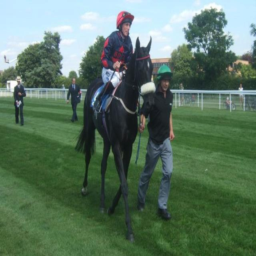

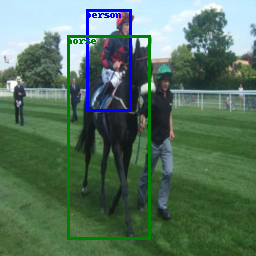

input: What is the interaction between person<loc_53><loc_700> and horse<loc_210><loc_1503>?
gt: <add_36>
pred: <add_36>
hold
hold


In [104]:
# 15, 56
gt, pred = show_result(dataset, idx=1, src_loc=True)
print(hoi_classes[int(gt.split('>')[0].split('_')[-1])])
print(hoi_classes[int(pred.split('>')[0].split('_')[-1])])

# V-COCO

In [111]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='vcoco', stage='finetune', phase='val', is_tgt_id=True, return_img_path=True)

In [112]:
with open('/data01/vcoco/hoi_classes.txt', "r") as f:
    hoi_classes = f.read().splitlines()

In [127]:
hoi_classes[12]

'talk_on_phone_instr'

/data01/vcoco/images/val2014/COCO_val2014_000000000328.jpg


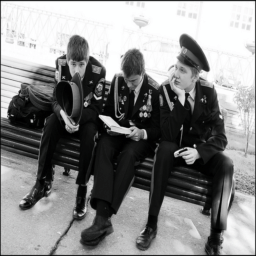

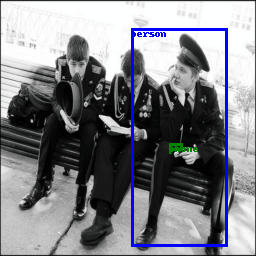

input: What is the interaction between person<loc_180><loc_1555> and cell phone<loc_906><loc_948>?
gt: <add_0>
pred: <add_0>


('<add_0>', '<add_0>')

In [129]:
# 16, 22
show_result(dataset, idx=3, src_loc=True, is_mask=False)

# ICDAR

In [11]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='icdar_loc', stage='finetune', phase='test')

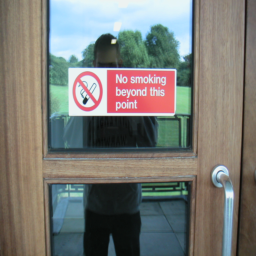

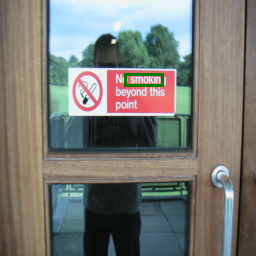

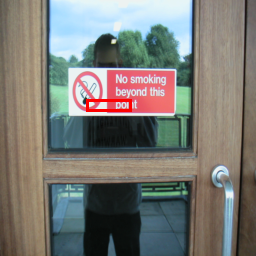

input: Which regions does the OCR text "smoking" describe?
gt: <loc_459><loc_545>
pred: <loc_613><loc_700>


('<loc_459><loc_545>', '<loc_613><loc_700>')

In [15]:
show_result(dataset, idx=196, src_loc=True)

# DeepFashion2

In [8]:
from data import get_dataset
dataset = get_dataset('/data01', dataset_name='deepfashion2_det', stage='finetune', phase='val', is_tgt_id=True)

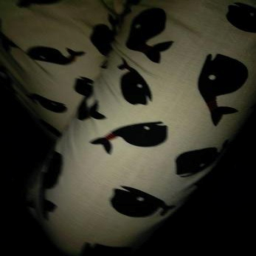

| 33708 | <add_8>  | -0.0022 | 99.78%
| 32100 | <loc_0>  | -0.0086 | 99.14%
| 33658 | <loc_1558> | -0.0063 | 99.37%
|     1 | </s>     | -0.0002 | 99.98%


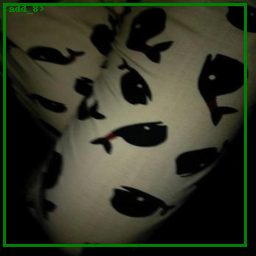

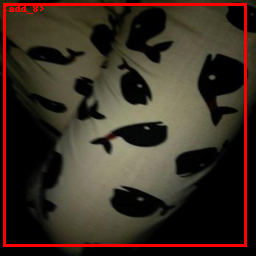

input: What objects are in the image?
gt: <add_8><loc_0><loc_1558>
pred: <add_8><loc_0><loc_1558>


('<add_8><loc_0><loc_1558>', '<add_8><loc_0><loc_1558>')

In [9]:
show_result(dataset, idx=100)